In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from docplex.mp.model import Model
import itertools

In [2]:
def create_graph(V,E_pos,E_neg,w):
  G=nx.Graph()

  for v in V:
    G.add_node(v)

  for u,v in E_pos:
    G.add_edge(u,v,weight=w.get((u,v),1),color='g')

  for u,v in E_neg:
    G.add_edge(u,v,weight=w.get((u,v),1),color='r')

  return G

In [81]:
V=set(range(1,4))
E_pos = {(1,2),(2,3)}
E_neg={(1,3)}
w={(1,2):3,(2,3):2,(1,3):3}
'''
E_pos = set()
E_neg = set()
'''

'''
for i in range(len(V)):
  for j in range(i+1,len(V)):
    if random.random()>0.5:
      if random.random()>0.5:
        E_pos.add((i,j))
      else:
        E_neg.add((i,j))
'''

'''
w={}
for u,v in E_pos:
  w[(u,v)]=random.uniform(0.5,4.5)
for u,v in E_neg:
  w[(u,v)] = random.uniform(0.5,4.5)
'''

print('nodes',V)
print('E_pos',E_pos)
print('E_neg',E_neg)
print('weight',w)




nodes {1, 2, 3}
E_pos {(2, 3), (1, 2)}
E_neg {(1, 3)}
weight {(1, 2): 3, (2, 3): 2, (1, 3): 3}


In [82]:
G=create_graph(V,E_pos,E_neg,w)

In [83]:
pos = nx.spring_layout(G)

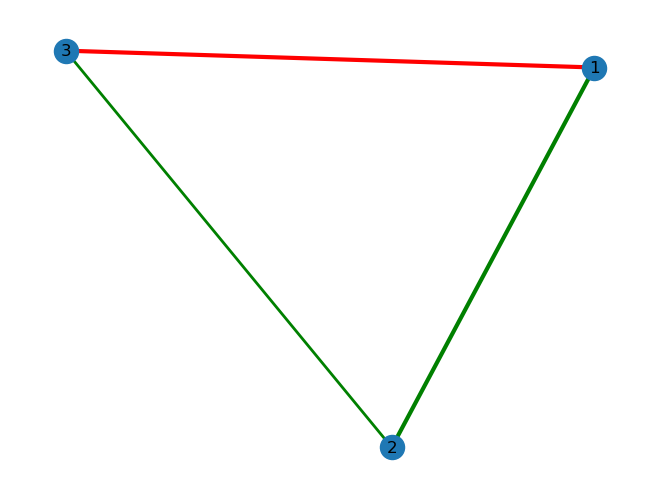

In [84]:
colors = [G[u][v]['color'] for u,v in G.edges()]
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G,pos,with_labels=True,edge_color=colors,width=weights)

In [85]:
A = nx.adjacency_matrix(G).todense()

In [86]:
kmeans = KMeans(n_clusters=2,n_init='auto')

In [87]:
clusters = kmeans.fit_predict(A)
clusters

array([1, 0, 0], dtype=int32)

In [88]:
for node,cluster in enumerate(clusters):
  print(f"Node {node} is in cluster {cluster}")

Node 0 is in cluster 1
Node 1 is in cluster 0
Node 2 is in cluster 0


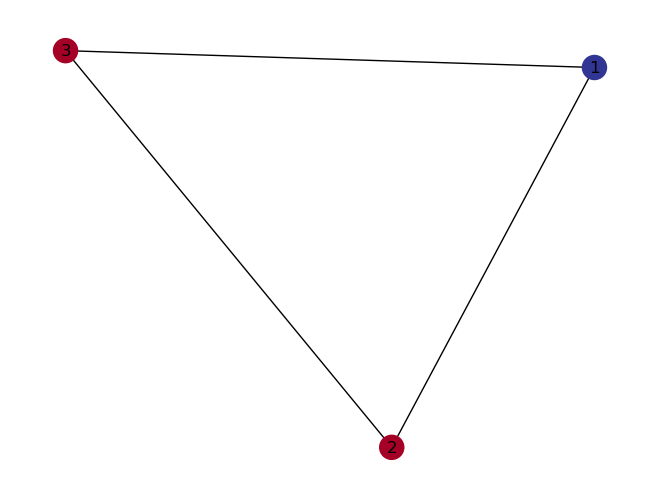

In [89]:
nx.draw(G,pos,with_labels=True,node_color =clusters, cmap=plt.cm.RdYlBu)

In [90]:
mdl = Model(name='disagree')

In [91]:
all_edges = set(E_pos).union(E_neg)
all_edges

{(1, 2), (1, 3), (2, 3)}

In [92]:
x = mdl.continuous_var_dict(keys=all_edges,lb=0,ub=1,name='x')

In [93]:
mdl.minimize(mdl.sum(w[i,j] * x[i,j] for i,j in E_pos) + mdl.sum(w[i,j] * (1-x[i,j]) for i,j in E_neg))

In [94]:
print(mdl.objective_expr)

2x_2_3+3x_1_2-3x_1_3+3


In [95]:
# 制約を追加
"""
for i, j in all_edges:
    if i != j:
      if (i,j) in x and (j,i) in x:       
        mdl.add_constraint(x[i, j] == x[j, i])
"""

for i, j in all_edges:
    for k in V:
        if i != j and i != k and j != k:
          if (i, k) in all_edges and (j, k) in all_edges:
              mdl.add_constraint(x[i, k] <= x[i, j] + x[j, k])

In [96]:
for constraint in mdl.iter_constraints():
    print(constraint)


x_1_3 <= x_2_3+x_1_2


In [97]:
solution = mdl.solve()

In [98]:
if solution:
  for i,j in all_edges:
    print(f'x[{i},{j}] = {x[i,j].solution_value}')
else:
  print('No solution found')

x[2,3] = 1.0
x[1,2] = 0
x[1,3] = 1.0


In [99]:
x_values = {(i,j):x[i,j].solution_value for i,j in all_edges}
for i in V:
  x_values[(i,i)]=0
x_values

{(2, 3): 1.0, (1, 2): 0, (1, 3): 1.0, (1, 1): 0, (2, 2): 0, (3, 3): 0}

In [79]:
c=3
C= set()
t=0

In [80]:
def cut(r,neighbors_list):
  inside = {j for j in neighbors_list if x_values[(i,j)] <r}
  outside = set(V) - inside
  cut_value = 0
  for u in inside:
    for v in outside:
      if (u,v) in E_pos or (v,u) in E_pos:
        cut_value += w.get((u,v), w.get((v,u),0))
  return cut_value

In [53]:
def vol(r,F,neighbors_list):
  inside = {j for j in neighbors_list if x_values[(i,j)] < r}
  outside = set(V) - inside
  inside_sum = sum(w.get((u, v), w.get((v, u), 0)) * x_values.get((u, v), x_values.get((v, u), 0)) for u,v in itertools.combinations(inside,2) if (u,v) in E_pos or (v,u) in E_pos)
  not_inside_sum = sum(w.get((u,v),w.get((v,u),0)) * (r - x_values.get((u, v), x_values.get((v, u), 0))) for u in inside for v in outside if (u,v) in E_pos or (v,u) in E_pos)
  vol_value = F/len(V) + inside_sum + not_inside_sum
  return vol_value
  
  

In [54]:
while V:
    print('t',t)
    i = random.choice(list(V))
    print('chosen_i',i)
    neighbors = [j for j, distance in x_values.items() if j[0] == i and distance < 1/c]
    neighbors_sorted = sorted(neighbors, key=lambda pair: x_values[(i, pair[1])])
    print('neighbors_sorted',neighbors_sorted)
    r_list = [x_values[(i, j)] for i, j in neighbors_sorted]
    print('r_list',r_list)
    neighbors_list = [j for i, j in neighbors_sorted]
    print('neighbors_list',neighbors_list)

    # cut(r) と vol(r) は以前に定義されていると仮定
    F = sum(w[(j,k)] * x_values[(j,k)] for j,k in E_pos)

    min_ratio = float('inf')
    best_r = None

    for r in r_list:
        if vol(r,F,neighbors_list) != 0:
            ratio = cut(r,neighbors_list) / vol(r,F,neighbors_list)
            if ratio < min_ratio:
                min_ratio = ratio
                best_r = r

    
    if best_r is None:
        best_r = 0
    print('best_r',best_r)

    B = {key[1] if key[0] == i else key[0] for key, distance in x_values.items() if i in key and distance <= best_r and ((key[0] == i and key[1] in V) or (key[1] == i and key[0] in V))}
    B.add(i)



    """
    B = {j for (i, j), distance in x_values.items() if distance <= best_r}
    """
    B.add(i)
    print(B)
    C.add(frozenset(B))

    V = V - B
    E_pos = E_pos - {pair for pair in E_pos if len(set(pair) & B) >= 1}
    t += 1


print('クラスタ',C)
print('final_t',t)

t 0
chosen_i 15
neighbors_sorted [(15, 16), (15, 15)]
r_list [0, 0]
neighbors_list [16, 15]
best_r 0
{16, 13, 15}
t 1
chosen_i 10
neighbors_sorted [(10, 11), (10, 10)]
r_list [0, 0]
neighbors_list [11, 10]
best_r 0
{9, 10, 11}
t 2
chosen_i 6
neighbors_sorted [(6, 7), (6, 6)]
r_list [0, 0]
neighbors_list [7, 6]
best_r 0
{5, 6, 7}
t 3
chosen_i 3
neighbors_sorted [(3, 1), (3, 3)]
r_list [0, 0]
neighbors_list [1, 3]
best_r 0
{1, 2, 3}
t 4
chosen_i 12
neighbors_sorted [(12, 12)]
r_list [0]
neighbors_list [12]
best_r 0
{12}
t 5
chosen_i 14
neighbors_sorted [(14, 14)]
r_list [0]
neighbors_list [14]
best_r 0
{14}
t 6
chosen_i 4
neighbors_sorted [(4, 13), (4, 4)]
r_list [0, 0]
neighbors_list [13, 4]
best_r 0
{4}
t 7
chosen_i 8
neighbors_sorted [(8, 9), (8, 8)]
r_list [0, 0]
neighbors_list [9, 8]
best_r 0
{8}
クラスタ {frozenset({14}), frozenset({9, 10, 11}), frozenset({8}), frozenset({5, 6, 7}), frozenset({16, 13, 15}), frozenset({1, 2, 3}), frozenset({12}), frozenset({4})}
final_t 8
